In [1]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
import csv
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy


1D UNBIASED Double Well Potential
==

## 1) The model 


Here we model the double well potential as a quartic function $V(q)= \sum_{i=0}^4 c_iq^i$ and choose a constant diffusion coefficient $D(q)=q$ :

The force parameter to pass to the simulator will then be : $F = - \frac{dV(q)}{dq}$

In [2]:
coeff=0.1*np.array([0,0,-4.5,0,0.1]) # coefficients of the free energy
free_energy = np.polynomial.Polynomial(coeff)
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]]) #coefficients of the free energy
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

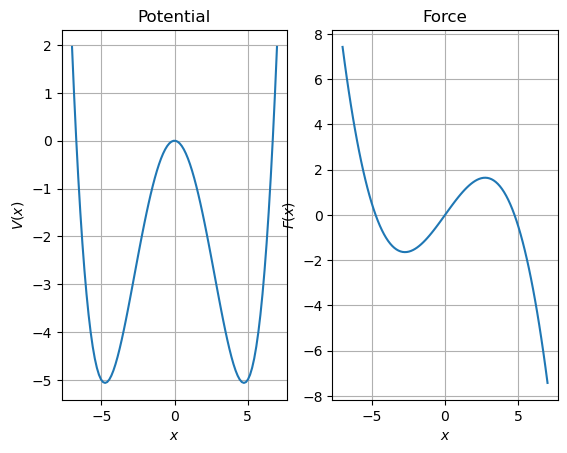

In [3]:
# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

## 2) Simulation

In [4]:
# Define model to simulate and type of simulator to use
dt=1e-3
model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)

In [5]:
ntraj=30
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0
# Calculate Trajectory
time_steps=10000
data = simulator.run(time_steps, q0, 1)

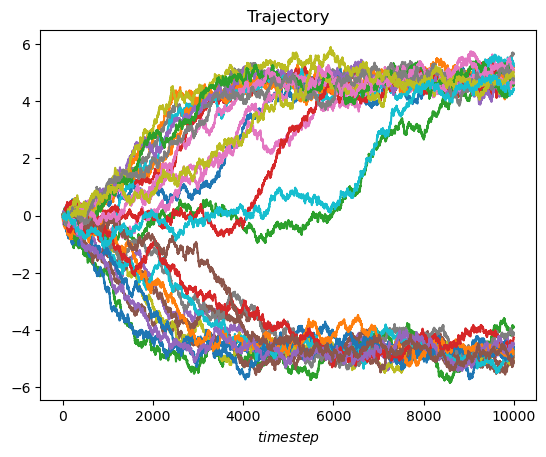

In [7]:
# Plot the trajecories
fig, axs = plt.subplots(1,1)
for n, trj in enumerate(data):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")
    axs.set_xlabel("$timestep$")

## 3) Model Training 

### 3.1) Training using same functional form of true force and diffusion 

In [8]:
# Parameters of the training
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))

trainmodel=fl.models.Overdamped(force = trainforce,diffusion=traindiff)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modfications
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel))) # made by the previous estimator and so in the end they will return the exact same results
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel))) 
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(deepcopy(data))
Ozk_res=Ozk_estimator.fit_fetch(deepcopy(data))
Shj_res=Shj_estimator.fit_fetch(deepcopy(data))
Eln_res=Eln_estimator.fit_fetch(deepcopy(data))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(data))
Drz_res=Drz_estimator.fit_fetch(deepcopy(data))

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  sig = np.sqrt(self._model.diffusion(x, **kwargs).ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:221: RuntimeWarning: overflow encountered in exp
  B = sig * np.sqrt((np.exp(2 * Lt * dt) - 1) / (2 * Lt))
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:223: RuntimeWarning: overflow encountered in exp
  elt = np.exp(Lt * dt) - 1
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:224: RuntimeWarning: overflow encountered in multiply
  A = x.ravel() + mu /

[ 2.50282889  0.2483735  -2.08536481 -1.52837542 -0.43411047  0.66462455
  1.58070591  2.65292717 -0.60354238 -2.61663983  0.49649825  0.49218213
  0.49870296  0.50310416  0.5114065   0.48873182  0.50172869  0.50856544
  0.50172756  0.49291249]
[ 3.07484244e-03 -1.73986167e-04 -1.70113192e-03 -1.77051837e-03
 -2.92281723e-04  5.70236741e-04  1.70301085e-03  2.31145552e-03
 -2.29645632e-04 -3.00433763e-03  5.00057634e-01  4.90193243e-01
  5.00861822e-01  5.06570180e-01  5.10500684e-01  4.89263470e-01
  5.03823403e-01  5.14251558e-01  4.96702321e-01  4.99959591e-01]
[ 3.07484244e-03 -1.73986167e-04 -1.70113192e-03 -1.77051837e-03
 -2.92281723e-04  5.70236741e-04  1.70301085e-03  2.31145552e-03
 -2.29645632e-04 -3.00433763e-03  5.00057634e-01  4.90193243e-01
  5.00861822e-01  5.06570180e-01  5.10500684e-01  4.89263470e-01
  5.03823403e-01  5.14251558e-01  4.96702321e-01  4.99959591e-01]
[ 2.60208954  0.25627357 -2.13177758 -1.52001992 -0.40213079  0.64402003
  1.54224131  2.72153949 -0.60

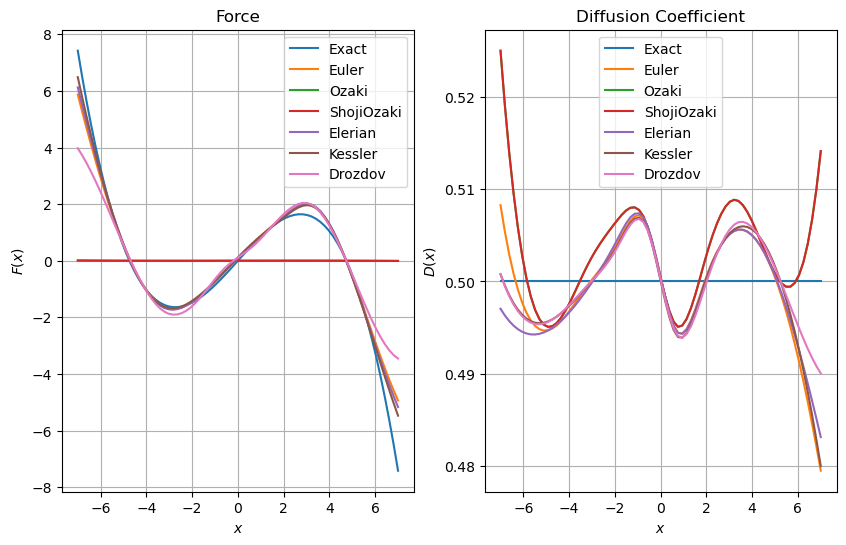

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
    print(res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()



Check if the methods are returning all the the same results

In [10]:
for i in range(len(names)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 

False False
False False
False False
False False
False False


### 3.2) Training using splines

In [12]:
# Parameters of the training

domain = fl.MeshedDomain.create_from_range(np.linspace(data.stats.min , data.stats.max , 10).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel)))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(deepcopy(data))
Ozk_res=Ozk_estimator.fit_fetch(deepcopy(data))
Shj_res=Shj_estimator.fit_fetch(deepcopy(data))
Eln_res=Eln_estimator.fit_fetch(deepcopy(data))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(data))
Drz_res=Drz_estimator.fit_fetch(deepcopy(data))

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:187: RuntimeWarning: overflow encountered in exp
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:187: RuntimeWarning: overflow encountered in multiply
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: overflow encountered in square
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:212: RuntimeWarning: invalid value encountered in sqrt
  si

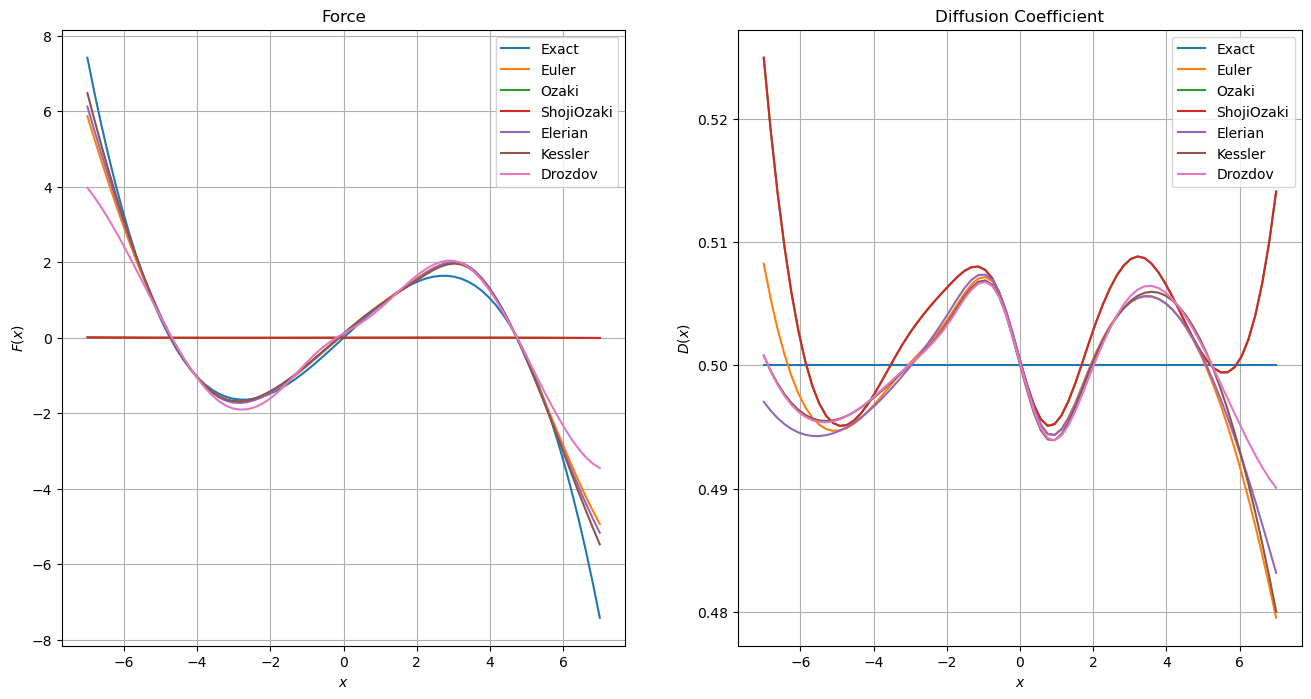

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
# axs.set_title("training using splines and 30 trajectories ")
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()

Check if the methods are returning all the the same results

In [14]:
for i in range(len(names)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 

False False
True True
False False
False False
False False


1D BIASED Double Well Potential
==

## 1) Model

Here we model the double well potential as a quartic function $V(q)= \sum_{i=0}^4 c_iq^i$ and choose a constant diffusion coefficient $D(q)=D$ : $\newline$
The force parameter to pass to the simulator will then be : $F = - \frac{dV(q)}{dq}$   $\newline$
Adiabaic bias used : $V_{bias}(q)=\frac{1}{2}k(q-q_0)^2  \longmapsto$ ABMD_Simulator $\newline$
The center of the parabola, $q_0$, is choosen as : $max(q,q_0)$ at every iteration 

In [16]:
coeff=0.1*np.array([0,0,-4.5,0,0.1]) # coefficients of the free energy
free_energy = np.polynomial.Polynomial(coeff)
force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]]) #coefficients of the free energy
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

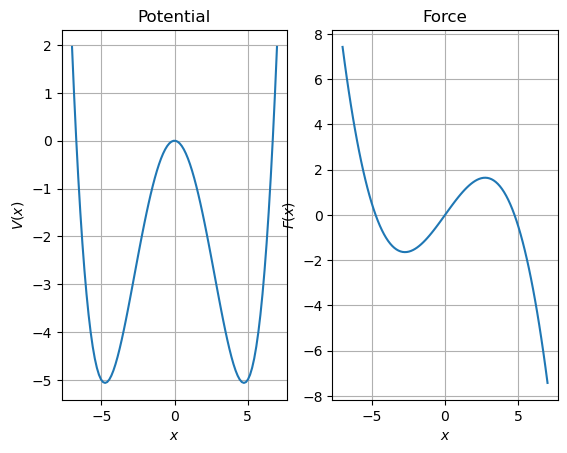

In [17]:
# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

## 2) Simulation

In [47]:
# Define model to simulate and type of simulator to use
dt=1e-3
biased_model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
biased_simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(biased_model_simu), dt, k=10.0, xstop=6.0) 
ntraj=30
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=-6.0
# Calculate Trajectory
time_steps=35000
biased_data = biased_simulator.run(time_steps, q0, 1)
xmax = np.concatenate(biased_simulator.xmax_hist, axis=1).T    # if you rerun simulator.run without reinializing the simulator object it will probably append the results making xmax twice as long 

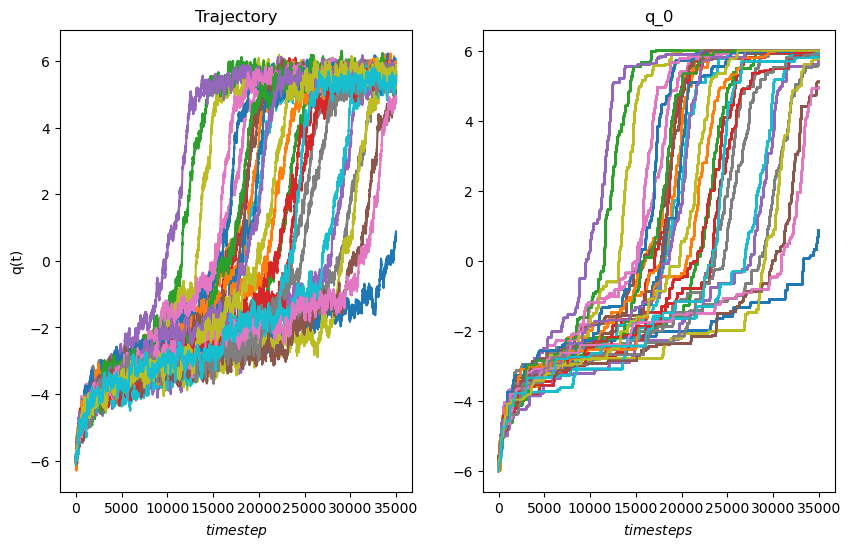

In [48]:
# Plot the trajecories
fig, axs = plt.subplots(1,2,figsize=(10,6))
for n, trj in enumerate(biased_data):
    axs[0].plot(trj["x"])
    axs[0].set_title("Trajectory")
    axs[0].set_xlabel("$timestep$")
    axs[0].set_ylabel("q(t)")
    axs[1].plot(xmax)
    axs[1].set_title("q_0")
    axs[1].set_xlabel("$timesteps$")



## 3) Model Training 

### 3.1) Training using same functional form of true force and diffusion 

In [49]:
# Parameters of the training

trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))

Eul_trainmodel=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=True)
Ozk_trainmodel=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=True)
Shj_trainmodel=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=True)
Eln_trainmodel=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=True)
Ksl_trainmodel=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=True)
Drz_trainmodel=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(Eul_trainmodel))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(Ozk_trainmodel))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(Shj_trainmodel))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(Eln_trainmodel))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(Ksl_trainmodel))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(Drz_trainmodel))

Eul_res=Eul_estimator.fit_fetch(deepcopy(biased_data))
Ozk_res=Ozk_estimator.fit_fetch(deepcopy(biased_data))
Shj_res=Shj_estimator.fit_fetch(deepcopy(biased_data))
Eln_res=Eln_estimator.fit_fetch(deepcopy(biased_data))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(biased_data))
Drz_res=Drz_estimator.fit_fetch(deepcopy(biased_data))

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:187: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in divide
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: divide by zero encountered in divide
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: divide by zero encountered in log
  return -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)
/home/dbersano/folie/folie/estimation/transitionDensity.py:11: RuntimeWarning: invalid

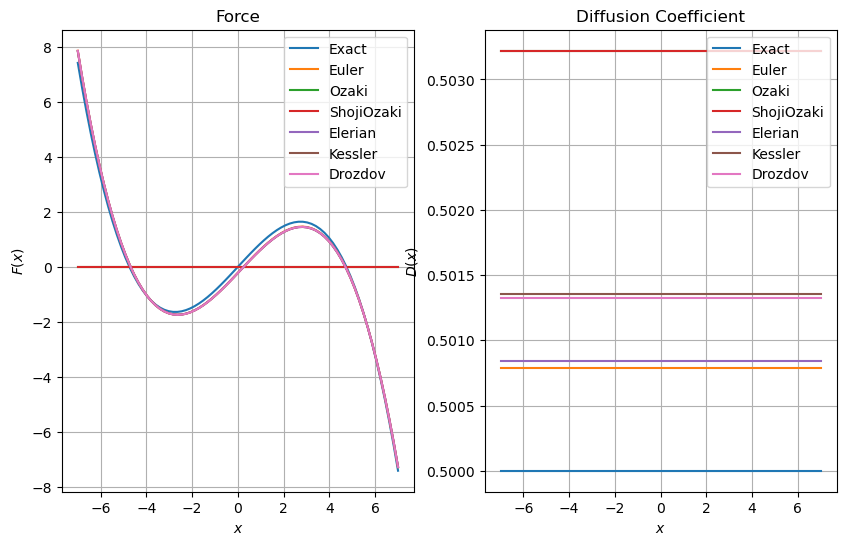

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
biased_model_simu.remove_bias()
axs[0].plot(xfa, biased_model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, biased_model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    res_vec[i].remove_bias()
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()


In [51]:
for i in range(len(names)-1):
    flag_force= (res_vec[i].force(xfa.reshape(-1, 1)) == res_vec[i+1].force(xfa.reshape(-1, 1))).all()
    flag_diff= (res_vec[i].diffusion(xfa.reshape(-1, 1)) == res_vec[i+1].diffusion(xfa.reshape(-1, 1))).all()
    print(flag_force, flag_diff)  # apparently they are 

False False
True True
False False
False False
False False


### 3.2) Training using splines

In [53]:
# Parameters of the training
n_knots= 5
domain = fl.MeshedDomain.create_from_range(np.linspace(biased_data.stats.min , biased_data.stats.max , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))
Ozk_estimator = fl.LikelihoodEstimator(fl.OzakiDensity(deepcopy(trainmodel)))
Shj_estimator = fl.LikelihoodEstimator(fl.ShojiOzakiDensity(deepcopy(trainmodel)))
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel)))
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(deepcopy(biased_data))
Ozk_res=Ozk_estimator.fit_fetch(deepcopy(biased_data))
Shj_res=Shj_estimator.fit_fetch(deepcopy(biased_data))
Eln_res=Eln_estimator.fit_fetch(deepcopy(biased_data))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(biased_data))
Drz_res=Drz_estimator.fit_fetch(deepcopy(biased_data))

res_vec = [Eul_res,Ozk_res,Shj_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 


/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:191: RuntimeWarning: invalid value encountered in sqrt
  Vt = np.sqrt(sig * (np.exp(Kt * dt) - 1) / Kt)
/home/dbersano/folie/folie/estimation/overdamped_transitionDensity.py:190: RuntimeWarning: invalid value encountered in log
  Kt = (2 / dt) * np.log(1 + temp / x.ravel())


Model is not biased
Model is not biased
Model is not biased
Model is not biased
Model is not biased
Model is not biased
Model is not biased


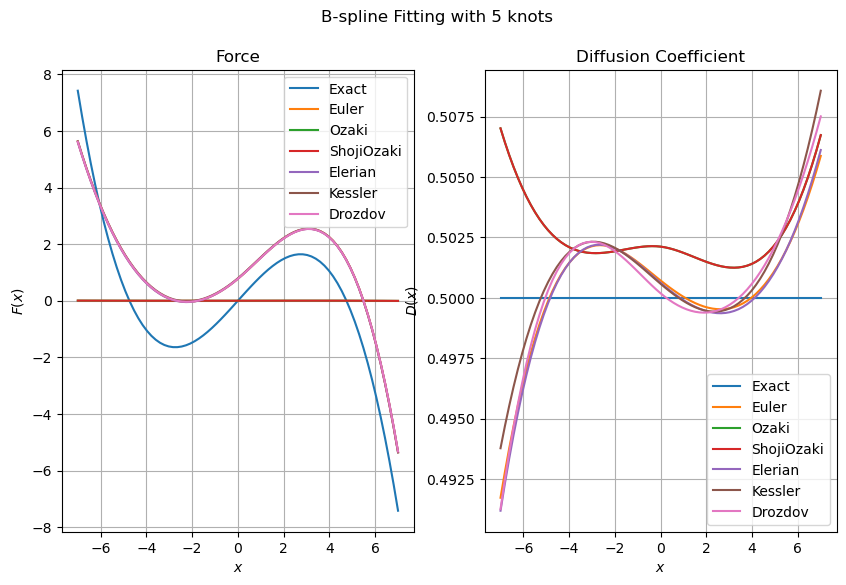

In [55]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')

xfa = np.linspace(-7.0, 7.0, 75)

#Plot exact quantities 
biased_model_simu.remove_bias()
axs[0].plot(xfa, biased_model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, biased_model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
#Plot inferred quantities 
names = ["Euler", "Ozaki", "ShojiOzaki", "Elerian", "Kessler", "Drozdov"]
for i in range(len(names)):
    res_vec[i].remove_bias()
    axs[0].plot(xfa, res_vec[i].force(xfa.reshape(-1, 1)), label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), label=names[i])
axs[0].legend()
axs[1].legend()